PARTIAL CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in partial df: 1051
Rows that have all features = NaN: 21
TRAIN rows: 924
VAL   rows: 106
TEST  rows: 21
Current device: cuda

=== Training & Predicting with ARIMA, plus Additional Diagrams ===
[ARIMA] ARIMA baseline model created.


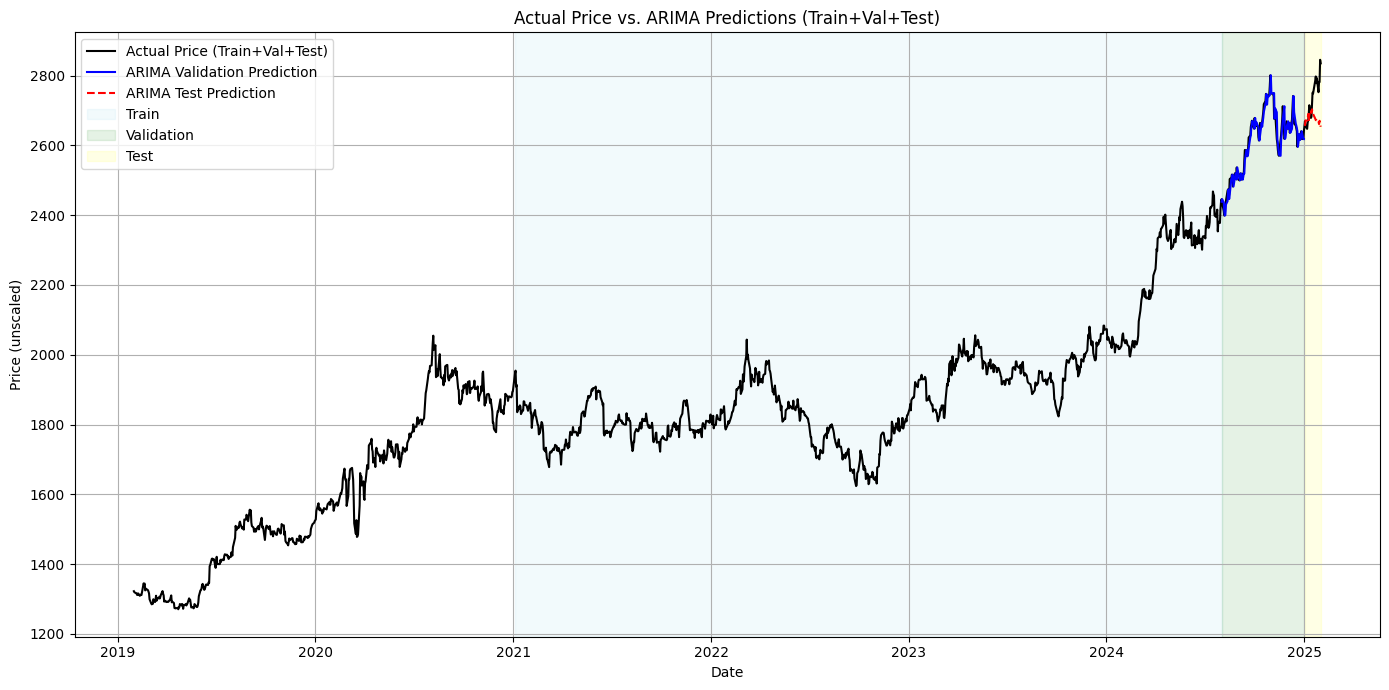

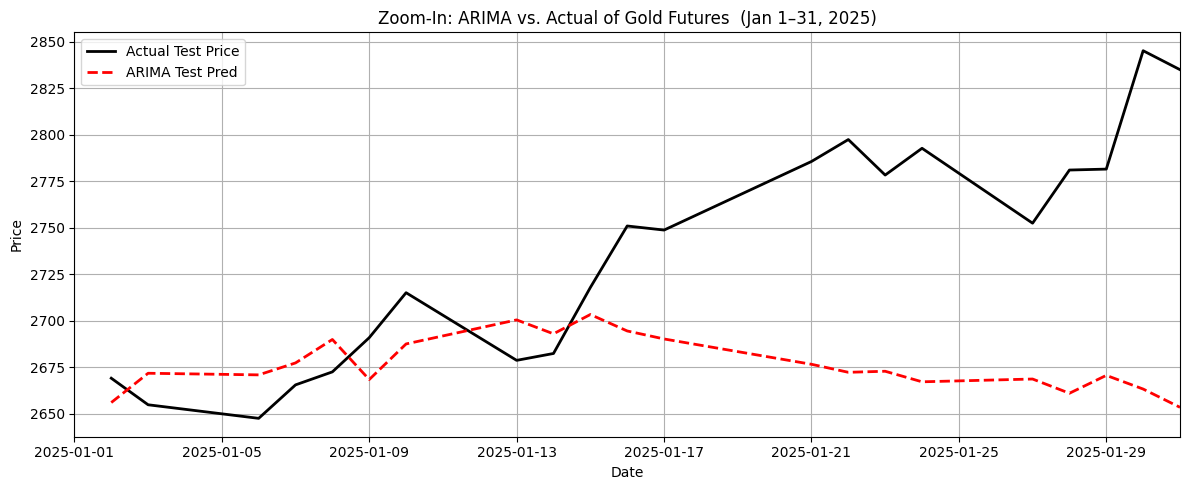

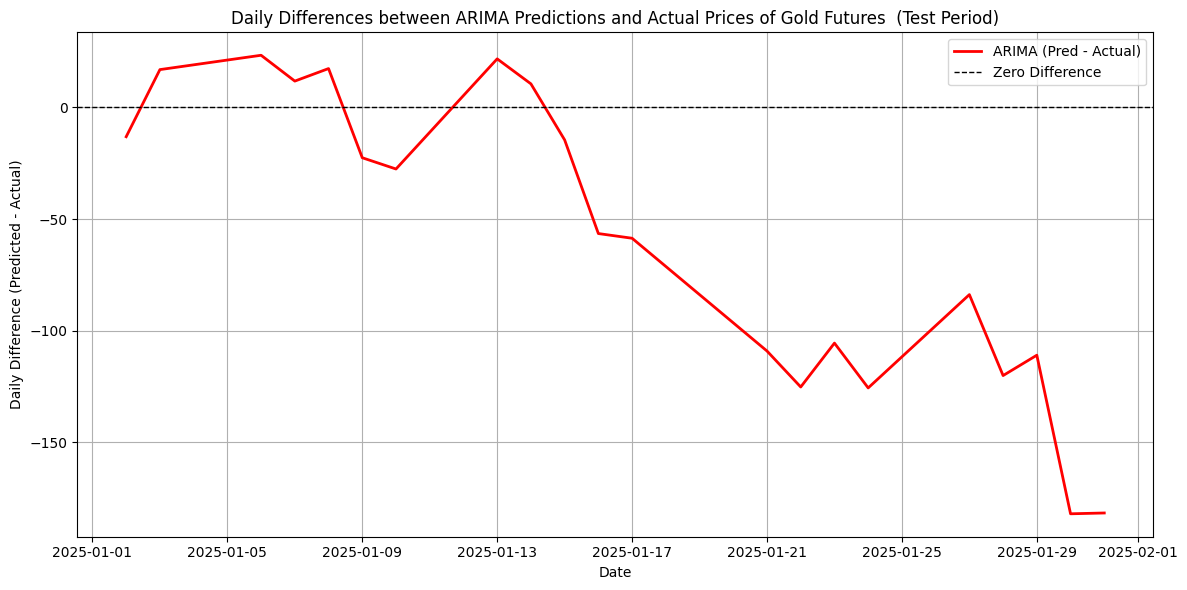

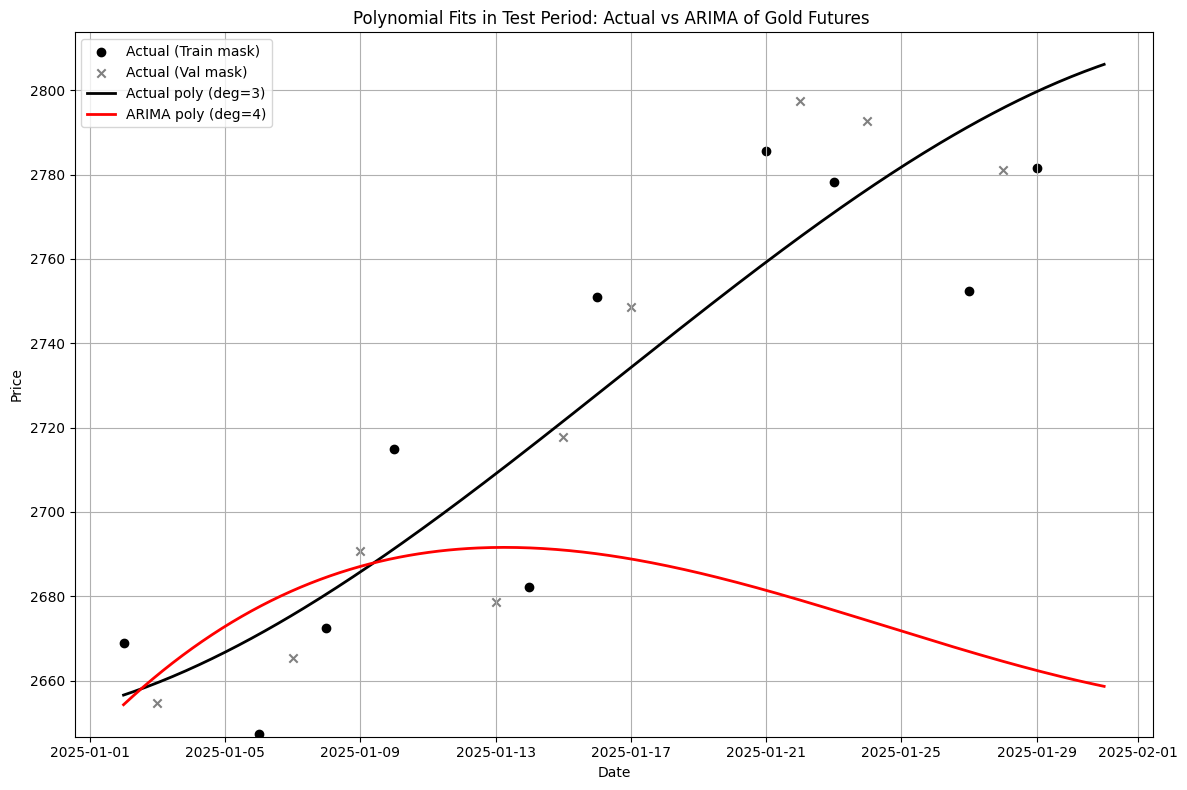

Actual: Best polynomial degree=3, Val MSE=458.5520
   y = -0.00579*x^3+349*x^2-7.02e+06*x+4.7e+10
ARIMA: Best polynomial degree=4, Val MSE=82.9130
   y = 1.62e-07*x^4-0.00653*x^3+0.0384*x^2+2.64e+06*x-2.66e+10


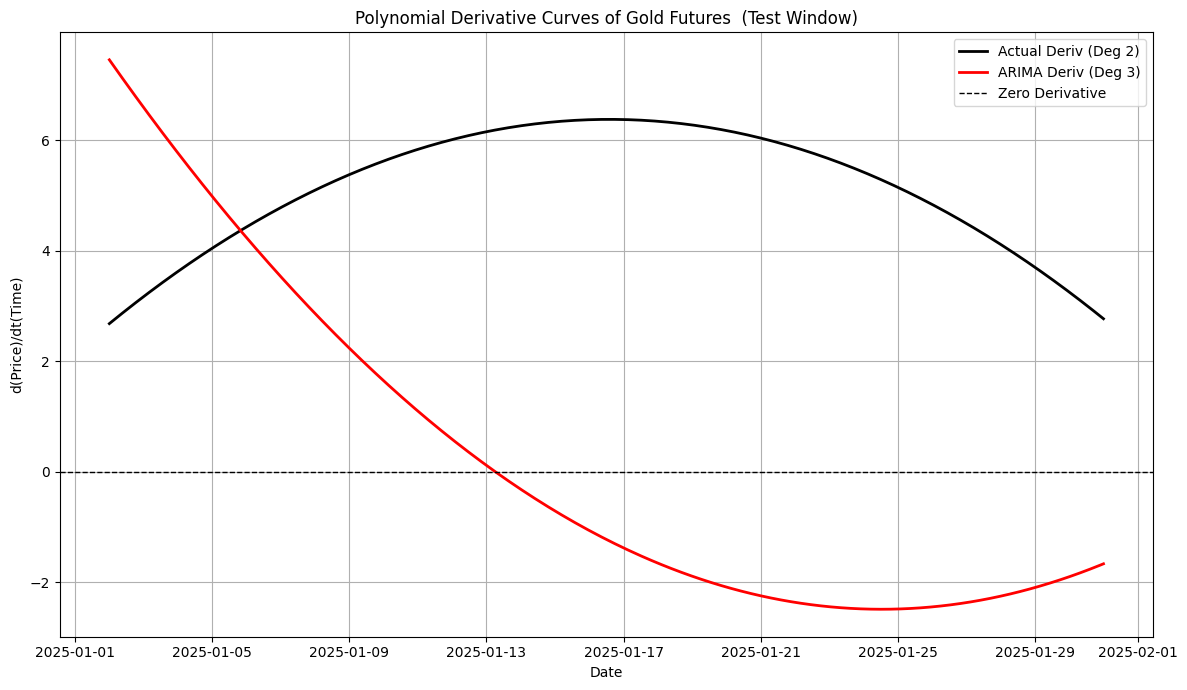


=== Polynomial Derivative Expressions ===
[Actual] (Deg 3) -> derivative: -0.0174*x^2+698*x-7.02e+06
[ARIMA] (Deg 4) -> derivative: 6.5e-07*x^3-0.0196*x^2+0.0768*x+2.64e+06


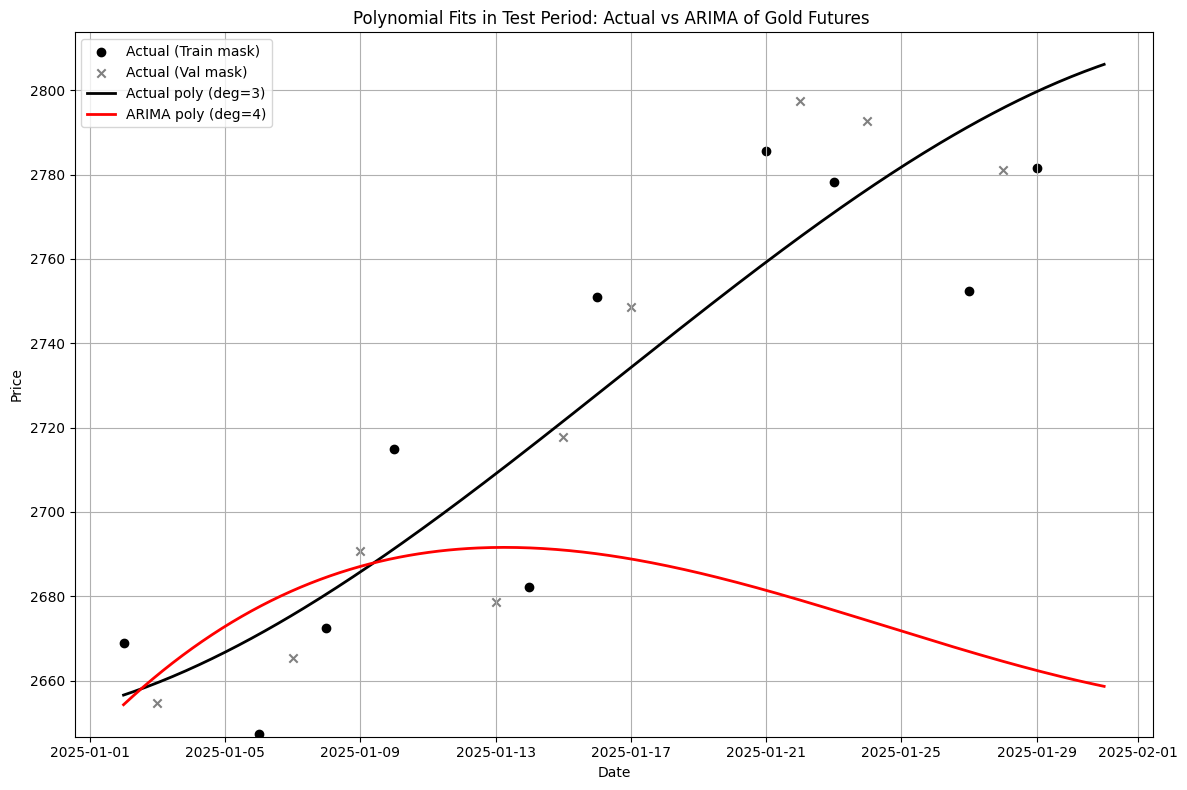

Actual: Best polynomial degree=3, Val MSE=458.5520
   y = -0.00579*x^3+349*x^2-7.02e+06*x+4.7e+10
ARIMA: Best polynomial degree=4, Val MSE=82.9130
   y = 1.62e-07*x^4-0.00653*x^3+0.0384*x^2+2.64e+06*x-2.66e+10


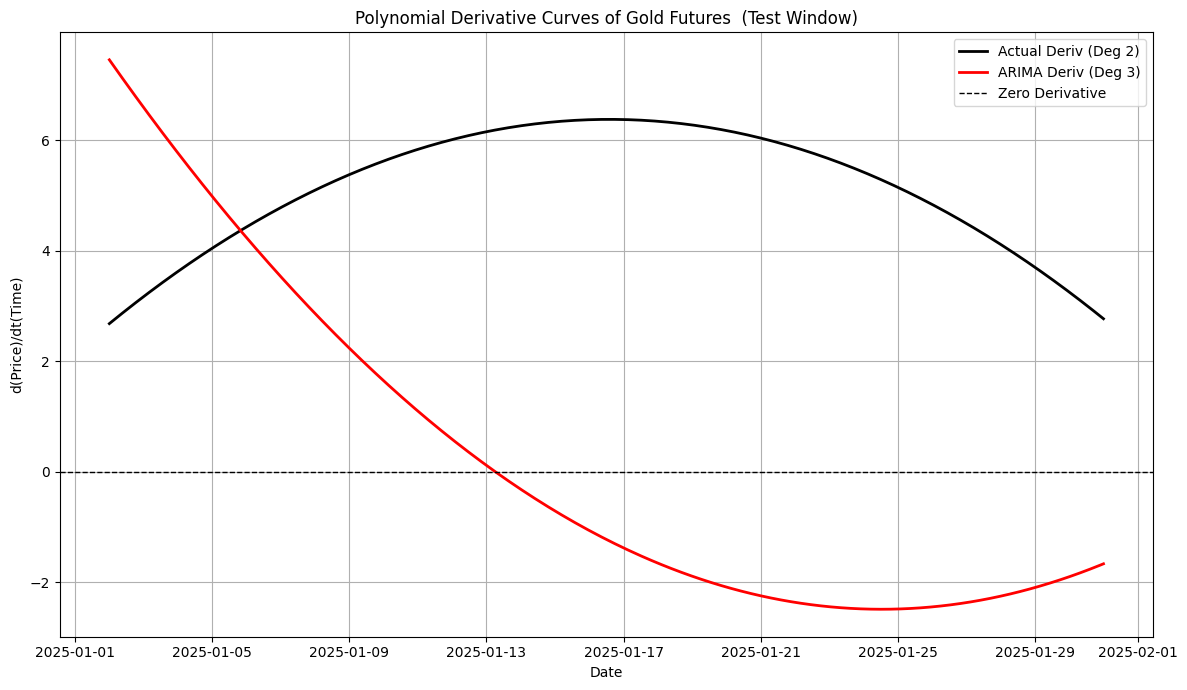


=== Polynomial Derivative Expressions ===
[Actual] (Deg 3) -> derivative: -0.0174*x^2+698*x-7.02e+06
[ARIMA] (Deg 4) -> derivative: 6.5e-07*x^3-0.0196*x^2+0.0768*x+2.64e+06

All tasks done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib
from statsmodels.tsa.arima.model import ARIMA
import torch.backends.cudnn as cudnn

###############################################################################
# 0. Suppress all warnings
###############################################################################
warnings.filterwarnings("ignore")

# Let CuDNN pick the fastest algorithm for your hardware
cudnn.benchmark = True

###############################################################################
# 1. Set random seeds
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 35
features = ["Price", "Open", "High", "Low"]

# (A) For training: partial CSV
csv_file_partial = "Gold Futures Historical Data.csv"

# (B) For final plotting + actual test data: complete CSV
csv_file_complete = "Gold Futures Historical Data_Complete.csv"

###############################################################################
# 2. Load & Clean the partial CSV (used for train/val/test)
###############################################################################
df = pd.read_csv(csv_file_partial)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("PARTIAL CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in partial df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

###############################################################################
# 3. Date cutoffs: TRAIN, VAL, TEST
###############################################################################
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

###############################################################################
# 5. Create Training Sequences (for pipeline consistency)
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4
)

###############################################################################
# 6. ARIMA Baseline Model Definition
###############################################################################
class ARIMAModel(nn.Module):
    def __init__(self, order=(1,0,0), epsilon=1e-4):
        """
        ARIMA baseline model (univariate per feature).
        order: ARIMA order, e.g., (1,0,0) is AR(1).
        epsilon: threshold below which std is near-constant => fallback last value.
        """
        super().__init__()
        self.order = order
        self.epsilon = epsilon
        
    def forward(self, x):
        # x: shape (batch, window, features)
        batch_predictions = []
        for sample in x:
            sample_pred = []
            for feature_idx in range(sample.shape[1]):
                series = sample[:, feature_idx].detach().cpu().numpy()
                if np.std(series) < self.epsilon:
                    forecast = series[-1]
                else:
                    try:
                        model = ARIMA(series, order=self.order)
                        model_fit = model.fit(disp=0)
                        forecast = model_fit.forecast(steps=1)[0]
                    except:
                        forecast = series[-1]
                sample_pred.append(forecast)
            batch_predictions.append(sample_pred)

        return torch.tensor(batch_predictions).float().to(x.device)

def train_model_arima():
    model = ARIMAModel(order=(1,0,0)).to(device)
    print("[ARIMA] ARIMA baseline model created.")
    return model

###############################################################################
# 7. Validation Predictions (non-iterative)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scl_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:,1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:,3]
    return pred_df

###############################################################################
# 8. Iterative Walk-Forward Test Predictions
###############################################################################
def iterative_walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE, noise_std=0.01):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    test_idx = df_work.index[df_work["Date"] >= test_start]
    if len(test_idx) == 0:
        raise ValueError("No test data available after test_start.")
    first_test_idx = test_idx[0]

    current_window = df_work.iloc[first_test_idx - window:first_test_idx][features].values
    test_dates = np.sort(df_work.loc[df_work["Date"] >= test_start, "Date"].unique())

    preds = []
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]

            # Add random noise
            noise = np.random.normal(scale=noise_std, size=pred_scaled.shape)
            pred_scaled_noisy = pred_scaled + noise

            preds.append((d, *pred_scaled_noisy))
            current_window = np.vstack((current_window[1:], pred_scaled_noisy))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scl_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:,1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:,3]
    return pred_df

###############################################################################
# 9A. Plot Full Timeline
###############################################################################
def evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete):
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_complete.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(14,7))
    # Entire actual line
    plt.plot(df_complete["Date"], df_complete["Price"], color="black", label="Actual Price (Train+Val+Test)")

    # ARIMA val
    if val_pred_df is not None and not val_pred_df.empty:
        plt.plot(val_pred_df["Date"], val_pred_df["Pred_Price_unscaled"],
                 color="blue", linestyle="-", label="ARIMA Validation Prediction")

    # ARIMA test
    if test_pred_df is not None and not test_pred_df.empty:
        plt.plot(test_pred_df["Date"], test_pred_df["Pred_Price_unscaled"],
                 color="red", linestyle="--", label="ARIMA Test Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, df_complete["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Actual Price vs. ARIMA Predictions (Train+Val+Test)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 9B. Zoom on Jan 1–31, 2025
###############################################################################
def plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete):
    start_zoom = pd.to_datetime("2025-01-01")
    end_zoom   = pd.to_datetime("2025-01-31")

    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_test_actual = df_complete[
        (df_complete["Date"] >= start_zoom) & (df_complete["Date"] <= end_zoom)
    ].copy()

    if test_pred_df is not None and not test_pred_df.empty:
        test_pred_df_zoom = test_pred_df[
            (test_pred_df["Date"] >= start_zoom) &
            (test_pred_df["Date"] <= end_zoom)
        ].copy()
    else:
        test_pred_df_zoom = pd.DataFrame()

    plt.figure(figsize=(12,5))
    if not df_test_actual.empty:
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color="black", linewidth=2, label="Actual Test Price")

    if not test_pred_df_zoom.empty:
        plt.plot(test_pred_df_zoom["Date"], test_pred_df_zoom["Pred_Price_unscaled"],
                 color="red", linestyle="--", linewidth=2, label="ARIMA Test Pred")

    plt.xlim([start_zoom, end_zoom])
    plt.title("Zoom-In: ARIMA vs. Actual of Gold Futures  (Jan 1–31, 2025)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 10. Additional Plots
###############################################################################
def plot_daily_difference(test_pred_df, complete_csv=csv_file_complete):
    """
    Plots the daily difference (Predicted - Actual) for the test period.
    """
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date","Price"]].dropna()

    df_merge = pd.merge(test_pred_df, df_test_actual, on="Date", how="inner")
    df_merge.sort_values("Date", inplace=True)
    df_merge["Difference"] = df_merge["Pred_Price_unscaled"] - df_merge["Price"]

    plt.figure(figsize=(12,6))
    plt.plot(df_merge["Date"], df_merge["Difference"], color="red", linewidth=2, label="ARIMA (Pred - Actual)")
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference (Predicted - Actual)")
    plt.title("Daily Differences between ARIMA Predictions and Actual Prices of Gold Futures  (Test Period)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def format_polynomial(coeffs):
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        sign = "+" if c >= 0 else ""
        if power > 1:
            terms.append(f"{sign}{c:.3g}*x^{power}")
        elif power == 1:
            terms.append(f"{sign}{c:.3g}*x")
        else:
            terms.append(f"{sign}{c:.3g}")
    expr = "".join(terms).replace("+-","-")
    return expr.strip("+")

def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

def polynomial_fitting_and_derivatives(test_pred_df, complete_csv=csv_file_complete):
    df_full = pd.read_csv(complete_csv)
    df_full.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_full["Date"] = pd.to_datetime(df_full["Date"], errors="coerce")
    df_full.sort_values("Date", inplace=True)
    for col in features:
        if col not in df_full.columns:
            df_full[col] = np.nan
        else:
            df_full[col] = df_full[col].astype(str).str.replace(",", "", regex=True)
            df_full[col] = pd.to_numeric(df_full[col], errors="coerce")

    df_test_actual = df_full[df_full["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date","Price"]].rename(columns={"Price":"Actual"})
    df_test_actual.dropna(subset=["Actual"], inplace=True)

    if test_pred_df is not None and not test_pred_df.empty:
        test_ren = test_pred_df[["Date","Pred_Price_unscaled"]].rename(columns={"Pred_Price_unscaled":"ARIMA"})
        df_poly = pd.merge(df_test_actual, test_ren, on="Date", how="inner")
    else:
        df_poly = df_test_actual.copy()
        df_poly["ARIMA"] = np.nan

    df_poly.dropna(axis=0, how="any", inplace=True)
    df_poly.reset_index(drop=True, inplace=True)

    df_poly["mdates_num"] = mdates.date2num(df_poly["Date"])

    n_points = len(df_poly)
    indices = np.arange(n_points)
    train_mask = (indices % 2 == 0)
    val_mask   = ~train_mask

    columns_to_fit = ["Actual","ARIMA"]
    best_poly = {}
    deg_candidates = range(1, 60)

    def val_mse(coeffs, x_val, y_val):
        y_val_pred = np.polyval(coeffs, x_val)
        return mean_squared_error(y_val, y_val_pred)

    for col in columns_to_fit:
        x_train = df_poly.loc[train_mask,"mdates_num"].values
        y_train = df_poly.loc[train_mask,col].values
        x_val   = df_poly.loc[val_mask,"mdates_num"].values
        y_val   = df_poly.loc[val_mask,col].values

        best_info = {"degree":None, "coeffs":None, "val_mse":float("inf")}
        for d in deg_candidates:
            coeffs = np.polyfit(x_train, y_train, d)
            this_mse = val_mse(coeffs, x_val, y_val)
            if this_mse < best_info["val_mse"]:
                best_info["degree"] = d
                best_info["coeffs"] = coeffs
                best_info["val_mse"] = this_mse
        best_poly[col] = best_info

    # Plot polynomial fits
    plt.figure(figsize=(12,8))
    # Plot actual data points for "Actual"
    plt.scatter(df_poly.loc[train_mask,"Date"], df_poly.loc[train_mask,"Actual"],
                color="black", marker="o", label="Actual (Train mask)")
    plt.scatter(df_poly.loc[val_mask,"Date"], df_poly.loc[val_mask,"Actual"],
                color="gray", marker="x", label="Actual (Val mask)")

    x_dense = np.linspace(df_poly["mdates_num"].min(), df_poly["mdates_num"].max(), 300)
    x_dates = [mdates.num2date(xx) for xx in x_dense]
    colors_map = {"Actual":"black", "ARIMA":"red"}

    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        coeffs = best_poly[col]["coeffs"]
        y_dense = np.polyval(coeffs, x_dense)
        plt.plot(x_dates, y_dense, color=colors_map.get(col,"gray"),
                 linewidth=2, label=f"{col} poly (deg={deg})")

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Polynomial Fits in Test Period: Actual vs ARIMA of Gold Futures ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print best polynomial expressions
    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        msev = best_poly[col]["val_mse"]
        expr = format_polynomial(best_poly[col]["coeffs"])
        print(f"{col}: Best polynomial degree={deg}, Val MSE={msev:.4f}")
        print(f"   y = {expr}")

    # Plot derivative curves
    plt.figure(figsize=(12,7))
    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        coeffs = best_poly[col]["coeffs"]
        d_coeffs = np.polyder(coeffs)
        y_deriv = np.polyval(d_coeffs, x_dense)
        plt.plot(x_dates, y_deriv, color=colors_map.get(col,"gray"),
                 linewidth=2, label=f"{col} Deriv (Deg {deg -1})")

    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Derivative")
    plt.xlabel("Date")
    plt.ylabel("d(Price)/dt(Time)")
    plt.title("Polynomial Derivative Curves of Gold Futures  (Test Window)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Finally, print derivative expressions
    print("\n=== Polynomial Derivative Expressions ===")
    for col in columns_to_fit:
        d_expr = derivative_expression(best_poly[col]["coeffs"])
        print(f"[{col}] (Deg {best_poly[col]['degree']}) -> derivative: {d_expr}")
    return best_poly
###############################################################################
# 11. MAIN
###############################################################################
if __name__ == "__main__":
    print("\n=== Training & Predicting with ARIMA, plus Additional Diagrams ===")
    
    # (A) Create ARIMA-based model
    model = train_model_arima()
    
    # (B) Validation predictions (half-blind)
    val_pred_df = half_blind_validation_preds_df(
        model,
        df_scaled,
        val_start=train_cutoff,
        val_end=val_cutoff,
        window=WINDOW_SIZE
    )
    
    # (C) Test predictions (iterative + noise)
    test_pred_df = iterative_walk_forward_test(
        model,
        df_all_scaled=df_scaled,
        test_start=test_cutoff,
        window=WINDOW_SIZE,
        noise_std=0.01
    )
    
    # (D) Evaluate + Plot entire timeline
    evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete)
    
    # (E) Zoom in on Jan 1–31, 2025
    plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete)

    # (F) Plot daily differences
    if test_pred_df is not None and not test_pred_df.empty:
        plot_daily_difference(test_pred_df, complete_csv=csv_file_complete)

    # (G) Polynomial Fitting + Derivative Plots
    polynomial_fitting_and_derivatives(test_pred_df, complete_csv=csv_file_complete)
    best_poly = polynomial_fitting_and_derivatives(test_pred_df, complete_csv=csv_file_complete)

    print("\nAll tasks done.")




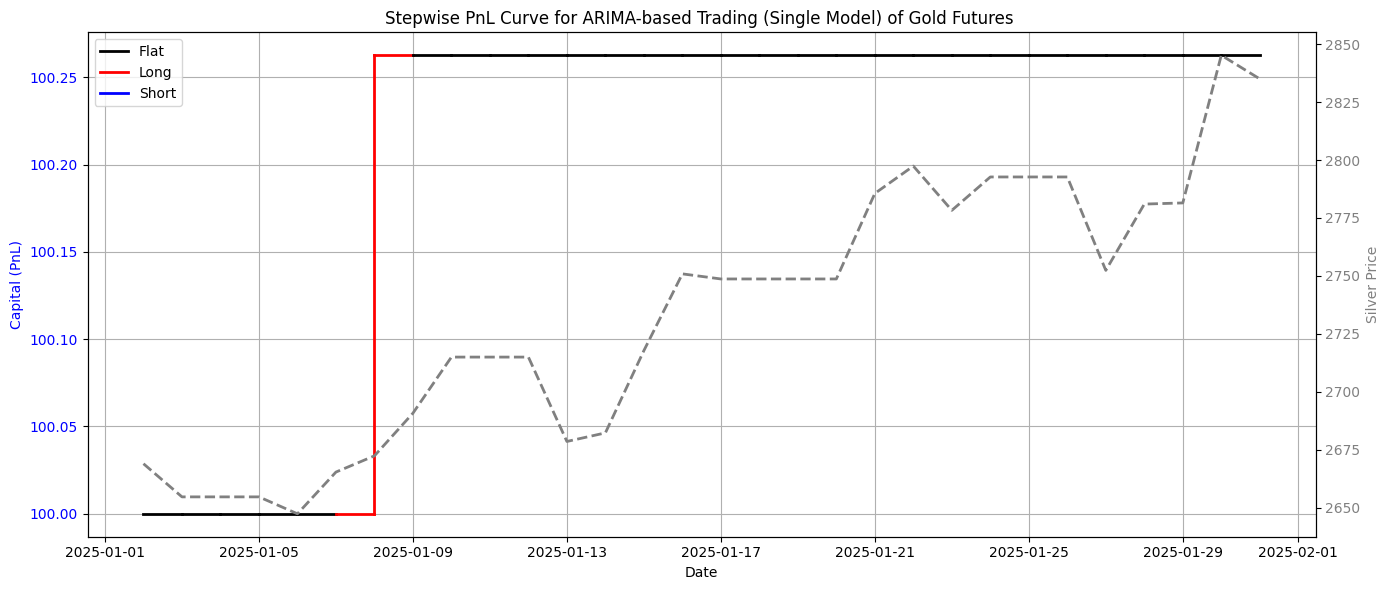

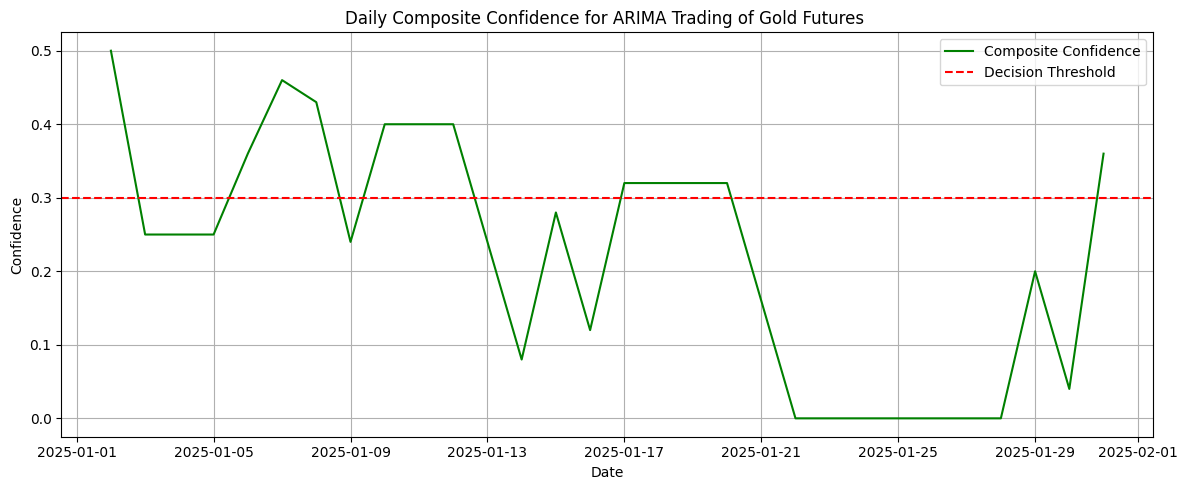

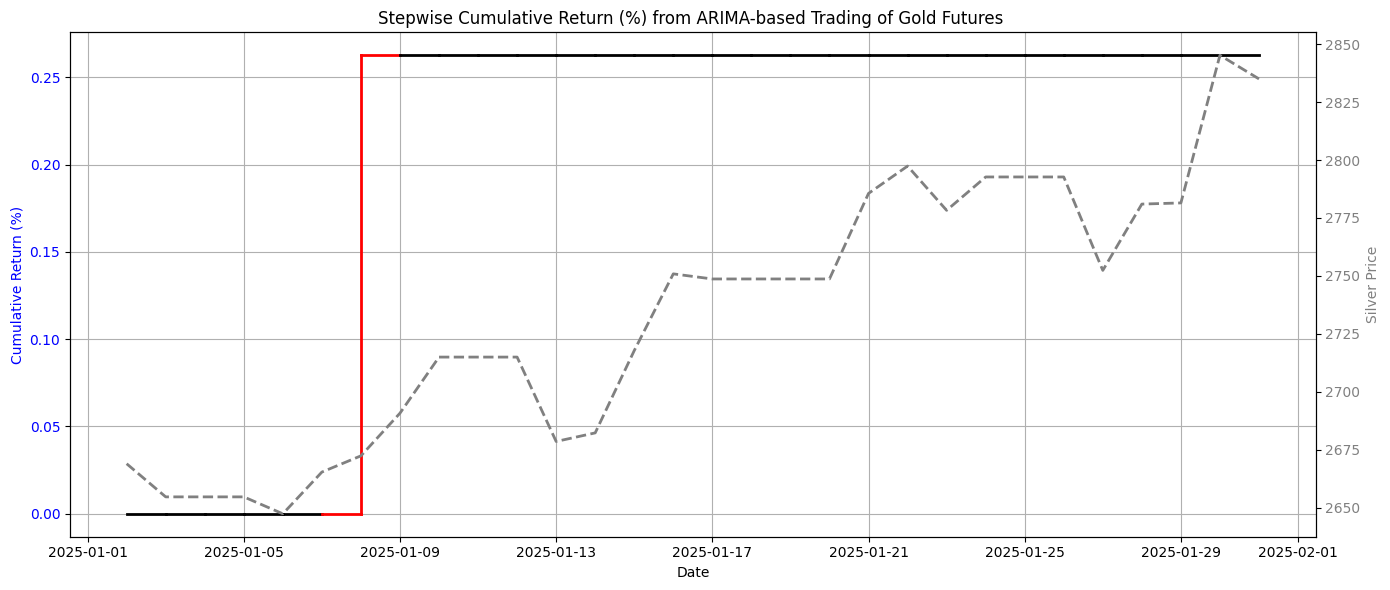


===== ARIMA Trade Log =====
Flat(ignored) | 2025-01-02 -> 2025-01-02 (1 days) | Entry=2669.000, Exit=2669.000, AbsDiff=0.000, Return=0.000%, EndCap=100.000
Flat(ignored) | 2025-01-03 -> 2025-01-03 (1 days) | Entry=2654.700, Exit=2654.700, AbsDiff=0.000, Return=0.000%, EndCap=100.000
        Flat | 2025-01-04 -> 2025-01-06 (3 days) | Entry=2654.700, Exit=2647.400, AbsDiff=7.300, Return=0.000%, EndCap=100.000
        Long | 2025-01-07 -> 2025-01-08 (2 days) | Entry=2665.400, Exit=2672.400, AbsDiff=7.000, Return=0.263%, EndCap=100.263
Flat(ignored) | 2025-01-09 -> 2025-01-09 (1 days) | Entry=2690.800, Exit=2690.800, AbsDiff=0.000, Return=0.000%, EndCap=100.263
        Flat | 2025-01-10 -> 2025-01-12 (3 days) | Entry=2715.000, Exit=2715.000, AbsDiff=0.000, Return=0.000%, EndCap=100.263
Flat(ignored) | 2025-01-13 -> 2025-01-13 (1 days) | Entry=2678.600, Exit=2678.600, AbsDiff=0.000, Return=0.000%, EndCap=100.263
        Flat | 2025-01-14 -> 2025-01-20 (7 days) | Entry=2682.300, Exit=2748.7

In [3]:
###############################################################################
# Trading Strategy for ARIMA Model
# (Append this snippet after you have test_pred_df and actual prices)
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

def execute_arima_trading_strategy(
    test_pred_df,
    complete_csv=csv_file_complete,
    initial_capital=100.0,
    w_static=0.3,     
    w_fit=0.3,        
    w_grad=0.4,       
    alpha_fit_up=0.2,
    alpha_fit_down=0.2,
    alpha_grad_up=0.5,
    alpha_grad_down=0.4,
    alpha_static_up=0.2,
    alpha_static_down=0.1,
    threshold=0.3,
    consecutive_all_wrong=0,
    MAX_CONSECUTIVE_ALL_WRONG=2,
):
    """
    Single-model ARIMA trading strategy with dynamic confidence and piecewise PnL.
      - Single-day segments (<2 days) are treated as 'Flat(ignored)'.
      - Produces:
          * Stepwise PnL curve (Capital)
          * Stepwise Cumulative Return (%) curve (exact same shape, just scaled)
          * Daily confidence plot
          * Printed trade log + final summary.
    """

    # 1) Merge ARIMA predictions with actual test data
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"])
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = (
                df_complete[col]
                .astype(str)
                .str.replace(",", "", regex=True)
                .astype(float)
            )

    # Filter for test period
    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date", "Price"]].rename(columns={"Price": "Actual"})
    df_test_actual.dropna(subset=["Actual"], inplace=True)

    df_arima = test_pred_df[["Date", "Pred_Price_unscaled"]].copy()
    df_arima.rename(columns={"Pred_Price_unscaled": "ARIMA"}, inplace=True)

    df_sim = pd.merge(df_test_actual, df_arima, on="Date", how="inner").dropna()
    df_sim.sort_values("Date", inplace=True)
    df_sim.reset_index(drop=True, inplace=True)

    if df_sim.empty:
        print("No overlapping dates between ARIMA predictions and actual test data.")
        return

    # 2) Initialize dynamic confidences
    dyn_static_conf = 0.5
    dyn_fit_conf    = 0.5
    dyn_grad_conf   = 0.5

    def clamp(x):
        return max(0.0, min(1.0, x))

    n_days = len(df_sim)
    signals = np.zeros(n_days, dtype=int)
    final_conf_values = np.zeros(n_days)

    # 3) Daily loop: update dynamic confidences & produce signals
    for i in range(n_days):
        if i > 0:
            actual_change = df_sim.loc[i, "Actual"] - df_sim.loc[i-1, "Actual"]
            pred_change   = df_sim.loc[i, "ARIMA"]  - df_sim.loc[i-1, "ARIMA"]

            # Fit correctness
            fit_error = abs(pred_change - actual_change)
            if fit_error < 1.0:
                dyn_fit_conf += alpha_fit_up
            else:
                dyn_fit_conf -= alpha_fit_down
            dyn_fit_conf = clamp(dyn_fit_conf)

            # Gradient correctness
            if np.sign(pred_change) == np.sign(actual_change):
                dyn_grad_conf += alpha_grad_up
            else:
                dyn_grad_conf -= alpha_grad_down
            dyn_grad_conf = clamp(dyn_grad_conf)

            # Static confidence
            if fit_error < 1.0:
                dyn_static_conf += alpha_static_up
            else:
                dyn_static_conf -= alpha_static_down
            dyn_static_conf = clamp(dyn_static_conf)

        final_conf = (w_static * dyn_static_conf
                    + w_fit    * dyn_fit_conf
                    + w_grad   * dyn_grad_conf)
        final_conf_values[i] = final_conf

        # Next-day signal
        if i < n_days - 1:
            next_pred_change = df_sim.loc[i+1, "ARIMA"] - df_sim.loc[i, "ARIMA"]
            if final_conf >= threshold:
                signals[i+1] = 1 if next_pred_change >= 0 else -1
            else:
                signals[i+1] = 0
            if consecutive_all_wrong > MAX_CONSECUTIVE_ALL_WRONG:
                signals[i+1] = -signals[i+1]

    df_sim["Signal"] = signals
    df_sim["Composite_Confidence"] = final_conf_values

    # 4) Reindex daily for stepwise lines
    df_sim.set_index("Date", inplace=True)
    all_days = pd.date_range(start=df_sim.index.min(), end=df_sim.index.max(), freq="D")
    df_sim = df_sim.reindex(all_days)
    df_sim["Actual"].ffill(inplace=True)
    df_sim["ARIMA"].ffill(inplace=True)
    df_sim["Signal"].fillna(0, inplace=True)
    df_sim["Composite_Confidence"].ffill(inplace=True)
    df_sim.reset_index(inplace=True)
    df_sim.rename(columns={"index": "Date"}, inplace=True)

    # 5) Piecewise trades -> stepwise PnL
    df_sim["Capital"] = initial_capital
    df_sim["Cumulative_PnL"] = 0.0
    df_sim["Cumulative_Return"] = 0.0

    # Segment finder
    def find_segments(df_, sig_col="Signal"):
        segs = []
        start_idx = 0
        curr_sig = df_.loc[0, sig_col]
        for idx in range(1, len(df_)):
            if df_.loc[idx, sig_col] != curr_sig:
                segs.append((start_idx, idx - 1, curr_sig))
                start_idx = idx
                curr_sig  = df_.loc[idx, sig_col]
        segs.append((start_idx, len(df_) - 1, curr_sig))
        return segs

    segments = find_segments(df_sim, "Signal")
    capital = initial_capital
    trade_log = []

    for (seg_start, seg_end, seg_sig) in segments:
        seg_days = seg_end - seg_start + 1
        start_date = df_sim.loc[seg_start, "Date"]
        end_date   = df_sim.loc[seg_end,   "Date"]
        entry_px   = df_sim.loc[seg_start, "Actual"]
        exit_px    = df_sim.loc[seg_end,   "Actual"]

        # Keep capital fixed from seg_start..seg_end
        for i_row in range(seg_start, seg_end + 1):
            df_sim.loc[i_row, "Capital"] = capital

        if seg_days < 2:
            # Single-day => treat as Flat(ignored)
            for i_row in range(seg_start, seg_end + 1):
                df_sim.loc[i_row, "Signal"] = 0
            trade_log.append({
                "Signal": "Flat(ignored)",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_px,
                "ExitPrice": exit_px,
                "AbsDiff": 0.0,
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
        elif seg_sig == 0:
            # Multi-day flat
            trade_log.append({
                "Signal": "Flat",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_px,
                "ExitPrice": exit_px,
                "AbsDiff": abs(exit_px - entry_px),
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
        else:
            # Real trade
            if seg_sig == 1:
                new_cap = capital * (exit_px / entry_px)
            else:
                new_cap = capital * (entry_px / exit_px)
            seg_ret_pct = (new_cap / capital - 1.0) * 100.0

            df_sim.loc[seg_end, "Capital"] = new_cap
            trade_log.append({
                "Signal": "Long" if seg_sig == 1 else "Short",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_px,
                "ExitPrice": exit_px,
                "AbsDiff": abs(exit_px - entry_px),
                "SegmentReturn(%)": seg_ret_pct,
                "EndCapital": new_cap
            })
            capital = new_cap

    df_sim["Capital"].ffill(inplace=True)
    df_sim["Cumulative_PnL"] = df_sim["Capital"] - initial_capital
    df_sim["Cumulative_Return"] = df_sim["Cumulative_PnL"] / initial_capital * 100.0

    ###########################################################################
    # 6) Final Plots
    ###########################################################################
    # (A) Stepwise PnL chart (Capital)
    fig, ax1 = plt.subplots(figsize=(14, 6))
    color_map = {0: "black", 1: "red", -1: "blue"}

    for i in range(1, len(df_sim)):
        sig_prev = df_sim.loc[i-1, "Signal"]
        # Horizontal step
        x_h = [df_sim.loc[i-1, "Date"], df_sim.loc[i, "Date"]]
        y_h = [df_sim.loc[i-1, "Capital"], df_sim.loc[i-1, "Capital"]]
        ax1.plot(x_h, y_h, color=color_map[sig_prev], linewidth=2)
        # Vertical step
        x_v = [df_sim.loc[i, "Date"], df_sim.loc[i, "Date"]]
        y_v = [df_sim.loc[i-1, "Capital"], df_sim.loc[i, "Capital"]]
        ax1.plot(x_v, y_v, color=color_map[sig_prev], linewidth=2)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Capital (PnL)", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(df_sim["Date"], df_sim["Actual"], color="gray", linestyle="--", linewidth=2)
    ax2.set_ylabel("Silver Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")

    legend_elems = [
        Line2D([0],[0], color="black", lw=2, label="Flat"),
        Line2D([0],[0], color="red",   lw=2, label="Long"),
        Line2D([0],[0], color="blue",  lw=2, label="Short"),
    ]
    ax1.legend(handles=legend_elems, loc="upper left")
    ax1.set_title("Stepwise PnL Curve for ARIMA-based Trading (Single Model) of Gold Futures ")
    plt.tight_layout()
    plt.show()

    # (B) Stepwise daily confidence
    plt.figure(figsize=(12, 5))
    plt.plot(df_sim["Date"], df_sim["Composite_Confidence"], label="Composite Confidence", color="green")
    plt.axhline(threshold, color="red", linestyle="--", label="Decision Threshold")
    plt.title("Daily Composite Confidence for ARIMA Trading of Gold Futures ")
    plt.xlabel("Date")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (C) Stepwise PnL % Return chart (same shape as capital)
    fig, ax1 = plt.subplots(figsize=(14, 6))
    for i in range(1, len(df_sim)):
        sig_prev = df_sim.loc[i-1, "Signal"]
        # Horizontal step
        x_h = [df_sim.loc[i-1, "Date"], df_sim.loc[i, "Date"]]
        y_h = [df_sim.loc[i-1, "Cumulative_Return"], df_sim.loc[i-1, "Cumulative_Return"]]
        ax1.plot(x_h, y_h, color=color_map[sig_prev], linewidth=2)
        # Vertical step
        x_v = [df_sim.loc[i, "Date"], df_sim.loc[i, "Date"]]
        y_v = [df_sim.loc[i-1, "Cumulative_Return"], df_sim.loc[i, "Cumulative_Return"]]
        ax1.plot(x_v, y_v, color=color_map[sig_prev], linewidth=2)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Return (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(df_sim["Date"], df_sim["Actual"], color="gray", linestyle="--", linewidth=2)
    ax2.set_ylabel("Silver Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")

    ax1.set_title("Stepwise Cumulative Return (%) from ARIMA-based Trading of Gold Futures ")
    plt.tight_layout()
    plt.show()

    ###########################################################################
    # 7) Print the trade log
    ###########################################################################
    print("\n===== ARIMA Trade Log =====")
    for trd in trade_log:
        print(
            f"{trd['Signal']:>12s} | {trd['StartDate'].date()} -> {trd['EndDate'].date()} "
            f"({trd['Days']} days) | "
            f"Entry={trd['EntryPrice']:.3f}, Exit={trd['ExitPrice']:.3f}, "
            f"AbsDiff={trd['AbsDiff']:.3f}, "
            f"Return={trd['SegmentReturn(%)']:.3f}%, "
            f"EndCap={trd['EndCapital']:.3f}"
        )

    # 8) Print final summary
    final_cap = df_sim["Capital"].iloc[-1]
    final_ret = df_sim["Cumulative_Return"].iloc[-1]
    print(f"\n===== ARIMA Trading Strategy Results =====")
    print(f"Final Capital          : {final_cap:.2f}")
    print(f"Final Cumulative Return: {final_ret:.2f}%")


if __name__ == "__main__":
    # ...
    # after polynomial_fitting_and_derivatives(...)
    execute_arima_trading_strategy(test_pred_df, complete_csv=csv_file_complete)
